In [1]:
import pandas as pd
from pathlib import Path

In [2]:
!pip install -q efficientnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [efficientnet]


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn import metrics
from sklearn.model_selection import train_test_split


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications.nasnet import NASNetLarge
from efficientnet.tfkeras import EfficientNetB7, EfficientNetL2



from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


2025-08-18 07:20:24.699023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755501624.712926       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755501624.717196       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 07:20:24.733749: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() #

print("REPLICAS: ", strategy.num_replicas_in_sync)

GCS_DS_PATH = KaggleDatasets().get_gcs_path()


EPOCHS = 40
BATCH_SIZE = 8 * strategy.num_replicas_in_sync


REPLICAS:  1


BackendError: Unexpected response from the service. Response: {'errors': ['Unauthenticated'], 'error': {'code': 16}, 'wasSuccessful': False}.

In [5]:
def format_path(st):
    return GCS_DS_PATH + '/images/' + st + '.jpg'


In [6]:
train = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
test = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
sub = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv')

train_paths = train.image_id.apply(format_path).values
test_paths = test.image_id.apply(format_path).values

train_labels = train.loc[:, 'healthy':].values


train_paths, valid_paths, train_labels, valid_labels = train_test_split(
     train_paths, train_labels, test_size=0.06, random_state=2020)


train_paths = train.image_id.apply(format_path).values
train_labels = train.loc[:, 'healthy':].values


NameError: name 'GCS_DS_PATH' is not defined

(1365, 2048, 3)


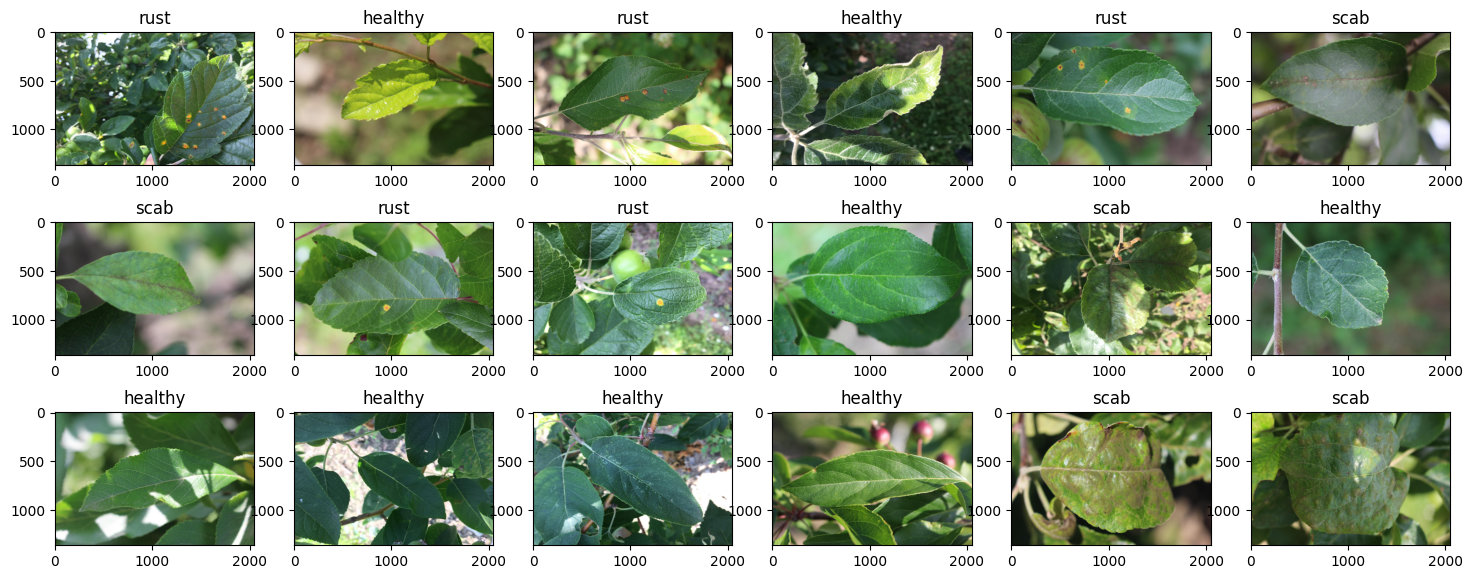

In [7]:
f, ax = plt.subplots(3, 6, figsize=(18, 7))
ax = ax.flatten()

for i in range(18):
    img = plt.imread(f'../input/plant-pathology-2020-fgvc7/images/Train_{i}.jpg')
    ax[i].set_title(train[train['image_id']==f'Train_{i}'].melt()[train[train['image_id']==f'Train_{i}'].melt().value == 1]['variable'].values[0])
    ax[i].imshow(img)
print(img.shape)


In [8]:
img_size = 768

def decode_image(filename, label=None, image_size=(img_size, img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None, seed=2020):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    
    if label is None:
        return image
    else:
        return image, label


In [9]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
     tf.data.Dataset
     .from_tensor_slices((valid_paths, valid_labels))
     .map(decode_image, num_parallel_calls=AUTO)
     .batch(BATCH_SIZE)
     .cache()
     .prefetch(AUTO)
 )

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)


NameError: name 'train_paths' is not defined

In [10]:
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch  LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch  LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))


SyntaxError: invalid syntax (3747005596.py, line 9)

In [11]:
# Here you can replace the EfficientNetB7 architecture with any other of the loaded ones and observe the result
# VGG16, VGG19, InceptionV3, InceptionResNetV2, DenseNet121, DenseNet169, DenseNet201, Xception,
# ResNet50, ResNet50V2, ResNet101V2, ResNet152V2, NASNetLarge, EfficientNetL2

def get_model(use_model):
    base_model =  use_model(weights='noisy-student',
                                 include_top=False, pooling='avg',
                                 input_shape=(img_size, img_size, 3))
    x = base_model.output
    predictions = Dense(train_labels.shape[1], activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

with strategy.scope():
    model = get_model(EfficientNetB7)
    
model.compile(optimizer='nadam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model.summary()


2025-08-18 07:20:37.388670: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


258068648/258068648 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


NameError: name 'train_labels' is not defined

In [12]:
history = model.fit(
            train_dataset, 
            steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
            callbacks=[lr_callback, ModelCheckpoint(filepath='my_ef_net_b7.h5', monitor='val_loss', save_best_only=True)],
            validation_data=valid_dataset, epochs=EPOCHS)


NameError: name 'model' is not defined

In [13]:
#plt.plot(history.history['sparse_categorical_accuracy'], 
plt.plot(history.history['categorical_accuracy'], label='Accuracy on the training set')
plt.plot(history.history['val_categorical_accuracy'], label='Accuracy on the test set')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [14]:
plt.plot(history.history['loss'], label='losses on the training set')
plt.plot(history.history['val_loss'], label='losses on the test set')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [15]:
#model.save(name_model)

model = tf.keras.models.load_model('my_ef_net_b7.h5')


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'my_ef_net_b7.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [16]:
probs = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs
sub.to_csv('submission.csv', index=False)
sub.head()


NameError: name 'model' is not defined